# SAT comparisons

[JR] Running various things here to try and understand SAT optical models,
with larger goal of understanding how to model thin window for S4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import yaml
from jbolo_funcs import *

k_B = 1.380649e-23 # Boltzmann's constant

# Make inline plots in this notebook, make them reasonable sizes, and with legible font size
%matplotlib inline
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8,4]

maindir = '/Users/ruhl/code/bolo_calc_runs/jbolo/SO'

In [2]:
ls yamls

Bicep3_90GHz.yaml                      SO_MPKH_20250225.yaml
Bicep3_thinwindow_90GHz.yaml           SO_MP_20250210.yaml
SAT_HWP_aggr_20241121_phase2.yaml      SO_goal_MP_20250212.yaml
SAT_HWP_aggr_20250126_thinwindow.yaml  SOlikeS4_MP_20250210.yaml
SAT_HWP_aggr_MF.yaml


# Run a suite of models and look at Trj's and NETs.


In [3]:

# Run a modified bicep3
#names = ['B3_orig', 'B3_modified','B3_thin_modified']
#bk_fixed_psat = True

# Or run S4 table
#bk_fixed_psat = False
#names = ['s4_orig','s4_modified','s4_modified_hwp','s4_thin']

# Or run SO-like models
bk_fixed_psat = False
names = ['SO_KHMP', 'SO_KHMP_modified','SO_KHMP_modified_thinwindow']

data = {}

def mods(sim):
    # BK motivated changes to instrument loading parameters
    sim['optical_elements']['baffle']['absorption'] = 0.013  # based on revised Bicep team value, black baffle
    sim['optical_elements']['window']['loss_tangent'] = 1.0e-4
    sim['optical_elements']['alumina_filt']['loss_tangent'] = 4.0e-4
    sim['optical_elements']['alumina_filt']['temperature'] = 50
    sim['optical_elements']['RTMLI_10']['absorption'] = [0.008, 0.008]
    sim['optical_elements']['RTMLI_10']['temperature'] = 175.

def hwp_mods(sim):
    # SO-ish? HWP parameters for MF
    #   See https://opg.optica.org/ao/fulltext.cfm?uri=ao-63-6-1618&id=546924#t002
    sim['optical_elements']['hwp']['obj_type'] = 'Bespoke'
    sim['optical_elements']['hwp']['temperature']=70.0
    sim['optical_elements']['hwp']['reflection'] = [0.03, 0.07]  # seems a little high given table 2 of Sakaguri etal.  Maybe (1.2, 6.1)%
    sim['optical_elements']['hwp']['absorption'] = [0.03, 0.06]  # seems reasonable given figure 12, but hard to tell.

for name in names:
    match name:
        case 'B3_orig':
            # Trying to emulate the paper H. Hui is corresponding author for.
            yamlfile = 'yamls/Bicep3_90GHz.yaml'
            sim = yaml.safe_load(open(yamlfile))
            if bk_fixed_psat:
                print('fixed psat')
                sim['bolo_config']['psat_method'] = 'specified'
                sim['channels']['MF_1']['psat'] = 1.1*4.5e-12 # from Bicep3 2021 paper, table 7, an average
                sim['channels']['MF_2']['psat'] = 1.1*7.0e-12 # guess
        case 'B3_modified':
            # Modified orig model to use use lower tand for window as in Eibert paper, but 
            # add back in the power in the alumina filter and the RTMLI.  Note that their alumina elements have stycast coatings.
            yamlfile = 'yamls/Bicep3_90GHz.yaml'
            sim = yaml.safe_load(open(yamlfile))
            if bk_fixed_psat:
                print('fixed psat')
                sim['bolo_config']['psat_method'] = 'specified'
                sim['channels']['MF_1']['psat'] = 1.1*4.5e-12 # from Bicep3 2021 paper, table 7, an average
                sim['channels']['MF_2']['psat'] = 1.1*7.0e-12 # guess
            # Modify
            mods(sim)
        case 'B3_thin_modified':
            # Like B3 modified, but thin window with higher-still loss tangent as in Eibert paper.
            yamlfile = 'yamls/Bicep3_90GHz.yaml'
            sim = yaml.safe_load(open(yamlfile))
            if bk_fixed_psat:
                print('fixed psat')
                sim['bolo_config']['psat_method'] = 'specified'
                sim['channels']['MF_1']['psat'] = 1.1*4.5e-12 # from Bicep3 2021 paper, table 7, an average
                sim['channels']['MF_2']['psat'] = 1.1*7.0e-12 # guess
            # Modify
            mods(sim)
            sim['optical_elements']['window']['loss_tangent'] = 2.6e-4   
            sim['optical_elements']['window']['thickness'] = 1.4e-3
        case 's4_orig':
            # A "not-split-bands" version of S4's original model.
            yamlfile = 'yamls/SAT_HWP_aggr_MF.yaml'
            #yamlfile = 'yamls/SAT_HWP_aggr_20241121_phase2.yaml'
            sim = yaml.safe_load(open(yamlfile))
        case 's4_modified':
            # modifying S4's orig model in same way as B3_modified.
            # Alumina mods may not make sense if not stycast coatings. ?
            yamlfile = 'yamls/SAT_HWP_aggr_MF.yaml'
            sim = yaml.safe_load(open(yamlfile))
            # Modify
            mods(sim)
            #sim['optical_elements']['window']['loss_tangent'] = 1.2e-4    # UHMWPE, not HDPE
            sim['optical_elements']['window']['loss_tangent'] = [2.65e-04, 2.88e-04]  # 
            #
        case 's4_modified_hwp':
            # modifying S4's orig model in same way as B3_modified.
            # Alumina mods may not make sense if not stycast coatings. ?
            yamlfile = 'yamls/SAT_HWP_aggr_MF.yaml'
            sim = yaml.safe_load(open(yamlfile))
            # Modify
            mods(sim)
            #sim['optical_elements']['window']['loss_tangent'] = 1.2e-4    # UHMWPE, not HDPE
            #sim['optical_elements']['window']['loss_tangent'] = [1.2e-04, 1.43e-04]  # like my SO scaling to 150, but 1.45 lower
            sim['optical_elements']['window']['loss_tangent'] =  [2.65e-04, 2.88e-04]
            hwp_mods(sim)
            #
        case 's4_thin':
            #  S4_modified in same way as B3_thin_modified, ie change window.
            yamlfile = 'yamls/SAT_HWP_aggr_MF.yaml'
            sim = yaml.safe_load(open(yamlfile))
            # Modify
            mods(sim)
            sim['optical_elements']['window']['loss_tangent'] =  [5.75e-04, 6.25e-04]  # 2.17 times the UHMWPE value
            sim['optical_elements']['window']['thickness'] = 1.4e-3
            hwp_mods(sim)
        case 'SO_KHMP':
            yamlfile = 'yamls/SO_MPKH_20250225.yaml'
            sim = yaml.safe_load(open(yamlfile))
            #sim['bolo_config']['psat_method'] = 'from_optical_power'
            #sim['bolo_config']['psat_factor'] = 3.0
        case 'SO_KHMP_modified':
            yamlfile = 'yamls/SO_MPKH_20250225.yaml'
            sim = yaml.safe_load(open(yamlfile))
            sim['bolo_config']['psat_method'] = 'from_optical_power'
            sim['bolo_config']['psat_factor'] = 3.0
            mods(sim)
            sim['optical_elements']['baffle']['temperature']=273
            sim['optical_elements']['window']['loss_tangent'] =  [2.65e-04, 2.88e-04]
        case 'SO_KHMP_modified_thinwindow':
            yamlfile = 'yamls/SO_MPKH_20250225.yaml'
            sim = yaml.safe_load(open(yamlfile))
            sim['bolo_config']['psat_method'] = 'from_optical_power'
            sim['bolo_config']['psat_factor'] = 3.0
            mods(sim)
            sim['optical_elements']['baffle']['temperature']=273
            sim['optical_elements']['window']['loss_tangent'] =  [5.75e-04, 6.25e-04]  # 2.17 times the UHMWPE value
            sim['optical_elements']['window']['thickness'] = 1.4e-3
            


    print(name, yamlfile)
    run_optics(sim)
    run_bolos(sim)
    #name = sim['version']['name']
    if name not in data.keys():
        data[name] = {}
    for ch in ['MF_1', 'MF_2']:
        if ch not in data[name].keys():
            data[name][ch] = {}
        data[name][ch]['sys_bandwidth'] = sim['outputs'][ch]['sys_bandwidth']/1e9
        data[name][ch]['sys_bandcenter'] = sim['outputs'][ch]['sys_bandcenter']/1e9
        data[name][ch]['NET_NC'] = 1e6*sim['outputs'][ch]['NET_NC_total']
        data[name][ch]['NET_C'] = 1e6*sim['outputs'][ch]['NET_C_total']
        data[name][ch]['P_opt'] = 1e12*sim['outputs'][ch]['P_opt']
        P_inst = 0
        for element in sim['outputs'][ch]['optics'].keys():
            P_inst += sim['outputs'][ch]['optics'][element]['P_opt']
        data[name][ch]['P_inst'] = 1e12*P_inst
        data[name][ch]['P_window'] = 1e12*sim['outputs'][ch]['optics']['window']['P_opt']
        data[name][ch]['P_atmos']  = 1e12*sim['outputs'][ch]['sources']['atmosphere']['P_opt']
        gain_bandwidth = sim['outputs'][ch]['sys_gain_bw_product']
        data[name][ch]['gain_bw'] = gain_bandwidth/1e9
        data[name][ch]['Trj_inst'] = P_inst/(k_B*gain_bandwidth)
        data[name][ch]['Trj_atmos'] = sim['outputs'][ch]['sources']['atmosphere']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_cmb'] = sim['outputs'][ch]['sources']['cmb']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_window'] = sim['outputs'][ch]['optics']['window']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_tot'] = sim['outputs'][ch]['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_baffle'] = sim['outputs'][ch]['optics']['baffle']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_rtmli'] = sim['outputs'][ch]['optics']['RTMLI_10']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_hwp'] = sim['outputs'][ch]['optics']['hwp']['P_opt']/(k_B*gain_bandwidth)
        data[name][ch]['Trj_aluminafilt'] = sim['outputs'][ch]['optics']['alumina_filt']['P_opt']/(k_B*gain_bandwidth)
        
        data[name][ch]['Trj_cryointernal'] = data[name][ch]['Trj_inst'] - data[name][ch]['Trj_baffle']  # non-instrument window loading
        data[name][ch]['Trj_4Kstuff'] = data[name][ch]['Trj_cryointernal'] - data[name][ch]['Trj_hwp'] - data[name][ch]['Trj_rtmli'] -data[name][ch]['Trj_aluminafilt'] -data[name][ch]['Trj_window']

print_optics(sim,'MF_1')
#items = ['P_window','Trj_window','P_inst','Trj_inst','P_atmos','Trj_atmos','P_opt','Trj_tot','NET_NC','gain_bw']

items = ['Trj_cmb','Trj_atmos', 'Trj_baffle','Trj_cryointernal','Trj_window','Trj_rtmli','Trj_hwp','Trj_aluminafilt','Trj_4Kstuff','Trj_inst','Trj_tot','NET_NC','NET_C','gain_bw','sys_bandwidth', 'sys_bandcenter']


#print('name'.ljust(15),end=' ')

print()
for ch in ['MF_1', 'MF_2']:
    if bk_fixed_psat:
        print('Fixed Psats: ')
    #else:
        #print('Psat = 2.5*P_optical: ')
    print(ch)
    print(' '.ljust(22),end='')
    for name in data.keys():
        print(f'{name.ljust(9)} ',end=' ')
    print()
    
    for item in items:
        print(f'{item.ljust(16)}: ',end='')
        for name in data.keys():
            print(f'{data[name][ch][item]:12.2f}',end=' ')
        print()
    print('------')
  

SO_KHMP yamls/SO_MPKH_20250225.yaml
SO_KHMP_modified yamls/SO_MPKH_20250225.yaml
SO_KHMP_modified_thinwindow yamls/SO_MPKH_20250225.yaml
MF_1
Element            Popt(pW)   Effic  Effic_cumul
detector       :    0.0000     0.7800    1.0000
lowpass        :    0.0000     0.8400    0.7800
lens2          :    0.0002     0.9629    0.6552
lyot           :    0.0078     0.4633    0.6309
lens1          :    0.0001     0.9640    0.2922
nylon_filt     :    0.0018     0.9825    0.2817
alumina_filt   :    0.1240     0.9564    0.2767
hwp            :    0.2117     0.9400    0.2646
RTMLI_10       :    0.1352     0.9920    0.2487
window         :    0.0632     0.9726    0.2468
baffle         :    0.3323     0.9870    0.2400
atmosphere     :    0.7510     0.9664    0.2369
cmb            :    0.0976     0.0000    0.2290
P_opticsonly_total = 8.7637e-13
P_optical_total =  1.7250e-12

MF_1
                      SO_KHMP    SO_KHMP_modified  SO_KHMP_modified_thinwindow  
Trj_cmb         :         1.05      

# Background information

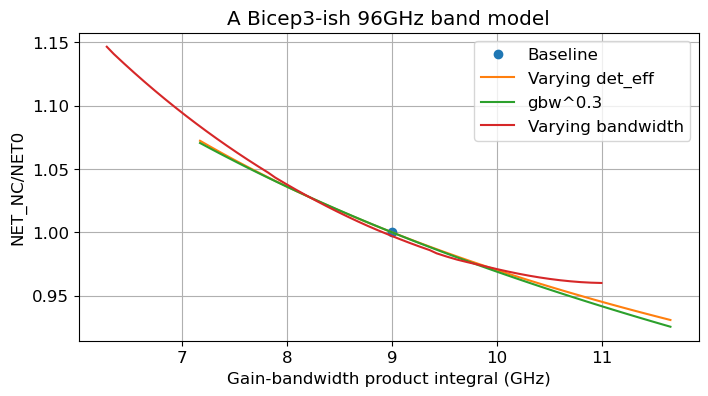

In [4]:
# Run a single model, and see how NET varies with det_eff
yamlfile = 'yamls/Bicep3_90GHz.yaml'
sim = yaml.safe_load(open(yamlfile))
sim['channels']['MF_1']['det_eff'] = 0.5

######## 

det_eff_vec = np.array([])
NET_vec = np.array([])
gbw_vec = np.array([])
bw_vec = np.array([])

for det_eff in np.linspace(0.4,0.65,50):
    sim['channels']['MF_1']['det_eff'] = det_eff
    run_optics(sim)
    run_bolos(sim)
    det_eff_vec = np.append(det_eff_vec,det_eff)
    NET_vec = np.append(NET_vec,1e6*sim['outputs']['MF_1']['NET_NC_total'])
    bw_vec =  np.append(bw_vec,     sim['outputs']['MF_1']['sys_bandwidth']/1e9)
    gbw_vec = np.append(gbw_vec,    sim['outputs']['MF_1']['sys_gain_bw_product']/1e9)

ii = np.argmin( np.abs(det_eff_vec-0.5) )
NET0 = NET_vec[ii]
gbw0 = gbw_vec[ii]
plt.plot(gbw0, [1],'.',markersize=12,label = 'Baseline')
plt.plot(gbw_vec,NET_vec/NET0,label='Varying det_eff')
plt.plot(gbw_vec,(gbw0/gbw_vec)**0.3,label='gbw^0.3')

##############
yamlfile = 'yamls/Bicep3_90GHz.yaml'
sim = yaml.safe_load(open(yamlfile))
sim['channels']['MF_1']['det_eff'] = 0.5


det_eff_vec = np.array([])
NET_vec = np.array([])
gbw_vec = np.array([])
bw_vec = np.array([])

#for det_eff in np.linspace(0.3,0.9,50):
    #sim['channels']['MF_1']['det_eff'] = det_eff

det_eff = sim['channels']['MF_1']['det_eff']
band_center = 96.0
for frac_bw in np.linspace(0.2,0.35,50):
    sim['channels']['MF_1']['nu_low'] = band_center*(1-frac_bw/2.0)
    sim['channels']['MF_1']['nu_high'] = band_center*(1+frac_bw/2.0)
    run_optics(sim)
    run_bolos(sim)
    det_eff_vec = np.append(det_eff_vec,det_eff)
    NET_vec = np.append(NET_vec,1e6*sim['outputs']['MF_1']['NET_NC_total'])
    bw_vec =  np.append(bw_vec,     sim['outputs']['MF_1']['sys_bandwidth']/1e9)
    gbw_vec = np.append(gbw_vec,    sim['outputs']['MF_1']['sys_gain_bw_product']/1e9)
plt.plot(gbw_vec,NET_vec/NET0,label='Varying bandwidth')



plt.xlabel('Gain-bandwidth product integral (GHz)')
plt.ylabel('NET_NC/NET0')
plt.title('A Bicep3-ish 96GHz band model')
plt.legend()
plt.grid()

### SO information

First, let's look at the paper they cite for loss tangent of their window, which is set to tand = 3.1e-4.  The paper is https://arxiv.org/pdf/1803.05228 , and its conclusion says their (upper limit on?) alpha = 0.03 +- 0.01 nepers/cm at 300 GHz, which as we can see below is the same as a loss tangent of 3.1e-4, as advertised.  However, the conclusion says this is an upper limit, confusingly quoted as an upper limit with an errorbar on it!  Looking at Figure 7, it looks like the t and t+r curves aren't at all consistent with a loss tangent until f>600GHz, maybe.  So, let's also look at what loss tangent causes the transmission to drop to 0.75 for a 20mm thick sample at 800 GHz, instead.

In [5]:
ltan = 3.1e-4
c = 3e8

alpha = 0.03
thickness_m = 0.02
thickness_cm = thickness_m*100

freq = 300e9
ind = 1.54

print('300 GHz stuff')
xx = np.exp( (-2. * np.pi * ind * ltan * thickness_m) / (c/freq))
print(f'loss tangent = {ltan:5.1e},  sample thickness = {thickness_cm:4.2}cm, Tranmission = {xx:5.3f}')

yy = np.exp(-alpha * thickness_cm)
print(f'alpha = {alpha:5.3f},           sample thickness = {thickness_cm:4.2}cm, Tranmission = {yy:5.3f}')

print()
print('800 GHz stuff')
freq = 800e9
ltan = 5.5e-4
xx = np.exp( (-2. * np.pi * ind * ltan * thickness_m) / (c/freq))
print(f'loss tangent = {ltan:5.1e},  sample thickness = {thickness_cm:4.2}cm, Tranmission = {xx:5.3f}')


300 GHz stuff
loss tangent = 3.1e-04,  sample thickness =  2.0cm, Tranmission = 0.942
alpha = 0.030,           sample thickness =  2.0cm, Tranmission = 0.942

800 GHz stuff
loss tangent = 5.5e-04,  sample thickness =  2.0cm, Tranmission = 0.753


Let's now look at Barkats etal (https://arxiv.org/pdf/1808.00570), figure 1.  The line of loss tangent vs frequency there is roughly consistent (by eye) with:

$$ tan\delta = \left[2.3 + \left(\frac{\nu}{260 \mbox{GHz}}\right) \right] \times 10^{-4} $$

Let's print out the loss tangent from that formula at a few relevant frequencies.


In [6]:
nu_ghz = np.array([90, 150, 300, 800, 1000])
tand = (2.3 + nu_ghz/260)*1e-4
for ii in range(len(nu_ghz)):
    print(f'{nu_ghz[ii]:5d} GHz : {tand[ii]:5.2e}')

   90 GHz : 2.65e-04
  150 GHz : 2.88e-04
  300 GHz : 3.45e-04
  800 GHz : 5.38e-04
 1000 GHz : 6.15e-04


These values of the loss tangent are consistent both with the plot in Barkats etal, and with the results quoted in Alessandro etal.  They are of course higher than the Bicep3 measurements at 250K, so I suggest we use these for "warmer" UHMWPE windows in Chile.  As in the Bicep3 measurements, I also think we should use a tandelta for the HMPE that is a factor of 2 or so higher than that for UHMWPE.

KH indicates that, roughly, one can tell from published numbers that SO is achieving NETs at least as good as (230, 330)uKrtsec at (90, 150)GHz.


#### Scratch space

In [7]:
# Sapphire

ind = 3.1
#ltan = 6e-5
ltan = 1.9e-4 # 90GHz, Afsar, 77K

thickness_m = 0.00375*3
freq = 90e9

xx = np.exp( (-2. * np.pi * ind * ltan * thickness_m) / (c/freq))
print(f'loss tangent = {ltan:5.1e},  sample thickness = {thickness_m*1000:4.2}mm, Tranmission = {xx:5.3f}')

loss tangent = 1.9e-04,  sample thickness = 1.1e+01mm, Tranmission = 0.988


In [8]:
# Duroid
ind = 1.41
ltan = 7e-4  # at 30-40GHz
thickness_m = 2*0.394/1000
freq = 150e9

xx = np.exp( (-2. * np.pi * ind * ltan * thickness_m) / (c/freq))
print(f'loss tangent = {ltan:5.1e},  sample thickness = {thickness_m*1000:4.2}mm, Tranmission = {xx:5.3f}')

loss tangent = 7.0e-04,  sample thickness = 0.79mm, Tranmission = 0.998
